In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer


In [3]:
import sys
sys.path.append('../')

from dl4time.data.databuilder import StockDataset, StockData, StockData_ensemble
from dl4time.data.preprocessing import MinMaxTransformation, NormalizationCurrentDay

from dl4time.model.Conv import Conv1D
from dl4time.model.RNN import RNN
from dl4time.model.lighting import Model

from dl4time.utils.evaluation import Evaluator

In [4]:
dates = pd.date_range('2000-01-02','2017-10-11',freq='B')
data_all = StockData('aapl', dates, transformation=NormalizationCurrentDay())

In [5]:
data_all.data['x_train'].shape

(3088, 60, 1)

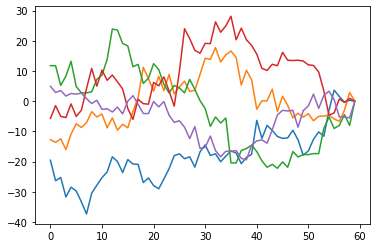

In [6]:
plt.plot(data_all.data['x_train'][0,:,:])
plt.plot(data_all.data['x_train'][100,:,:])
plt.plot(data_all.data['x_train'][200,:,:])
plt.plot(data_all.data['x_train'][300,:,:])
plt.plot(data_all.data['x_train'][400,:,:])
plt.show()

In [7]:
# import os
# symbols = [name.split(".")[0] for name in os.listdir("../Data_Folder/Stocks")]
# symbols.sort()

# dates = pd.date_range('2000-01-02','2017-10-11',freq='B')
# data_all = StockData_ensemble(symbols, dates, transformation=NormalizationCurrentDay(), max_num=2000)

# print(data_all.data['y_test'].shape)
# print(data_all.data['x_test'].shape)

In [8]:
import pickle
with open('../Data_Folder/Stocks_all.pickle', 'rb') as f:
    data_all = pickle.load(f)

import pickle
with open('../Data_Folder/Stocks_all.pickle', 'wb') as f:
    pickle.dump(data_all, f) 

In [9]:
dataloader_params = {'batch_size': 1024,
                     'num_workers': 2}

net = RNN(input_dim=1, hidden_dim=128, num_layers=3, output_dim=1)
model_lstm = Model(net, data_all, dataloader_params=dataloader_params)
dl = model_lstm.train_dataloader()

In [10]:
%lprun
dataloader_params = {'batch_size': 1024,
                     'num_workers': 1}

net = RNN(input_dim=1, hidden_dim=128, num_layers=3, output_dim=1)
model_lstm = Model(net, data_all, dataloader_params=dataloader_params)



In [ ]:
trainer = Trainer(max_epochs=20, gpus=0)
trainer.fit(model_lstm)

trainer.test()

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


In [ ]:
symbol = "aapl"
stock = StockData(symbol, dates, transformation=NormalizationCurrentDay())
stock.inference(model_lstm)

stock_evaluator = Evaluator()
stock_evaluator.evaluate(pd.Series(stock.y_pred['test'].flatten()), pd.Series(stock.y_true['test'].flatten()))
print(stock_evaluator.metrics)

stock.plot()

In [ ]:
dataloader_params = {'batch_size': 256,
                     'num_workers': 4}

#net = LSTM(input_dim=1, hidden_dim=64, num_layers=2, output_dim=1)
net2 = Conv1D(in_channels=1, output_dim=1)
model_Conv1D = Model(net2, data_container=data_all)

trainer = Trainer(max_epochs=10, gpus=1)
trainer.fit(model_Conv1D)

trainer.test()

In [ ]:
symbol = "aapl"
stock = StockData(symbol, dates, transformation=NormalizedTransformation())
stock.inference(model_Conv1D)

stock_evaluator = Evaluator()
stock_evaluator.evaluate(pd.Series(stock.y_pred['test'].flatten()), pd.Series(stock.y_true['test'].flatten()))
print(stock_evaluator.metrics)

stock.plot()

In [ ]:
symbol = "ibm"
stock = StockData(symbol, dates, transformation=NormalizedTransformation())
stock.inference(model_Conv1D)

stock_evaluator = Evaluator()
stock_evaluator.evaluate(pd.Series(stock.y_pred['test'].flatten()), pd.Series(stock.y_true['test'].flatten()))
print(stock_evaluator.metrics)

stock.plot()